In [140]:
# Data
using NamedArrays

nodes = [:S, :K, :P, :gamma, :L, :B, :O, :beta, :C, :M, :R, :alpha]
us = [:K, :L, :C]
producers = [us..., :gamma, :beta, :alpha]
consumers = [:S, :K, :P, :L, :B, :O, :C, :M, :R]

edges = [(:K, :P), (:S, :P), (:P, :L), (:P, :gamma), 
    (:gamma, :B), (:gamma, :L), (:gamma, :R), (:L, :B), (:B, :O),
    (:O, :beta), (:beta, :R), (:beta, :C), (:beta, :M),
    (:alpha, :gamma), (:alpha, :S), (:alpha, :R)]
edges = [edges; [(j, i) for (i, j) in edges]]

dist_vec = [1, 2, 6, 3, 4, 5, 7, 5, 3, 4, 2, 2, 3, 5, 5, 5]*100
distance = Dict(zip(edges, [dist_vec; dist_vec]))

days = [1:4;]

loss = 0.0005

matrix = zeros(length(consumers), length(days))
demand = NamedArray(matrix, (consumers, days), ("Consumer","Day"))
demand[:S, 1]=40.8; demand[:S, 2]=100; demand[:S, 3]=50.5; demand[:S, 4]=150.8;
demand[:P, 1]=28.8; demand[:P, 2]=30.3; demand[:P, 3]=28.8; demand[:P, 4]=20.5;
demand[:K, 1]=27.3; demand[:K, 2]=27.3; demand[:K, 3]=27.3; demand[:K, 4]=50.5;
demand[:L, 1]=30.1; demand[:L, 2]=28.8; demand[:L, 3]=27.3; demand[:L, 4]=55.2;
demand[:C, 1]=30.0; demand[:C, 2]=25.5; demand[:C, 3]=31.2; demand[:C, 4]=45.5;
demand[:B, 1]=30.1; demand[:B, 2]=31.5; demand[:B, 3]=30.1; demand[:B, 4]=35.1;
demand[:O, 1]=13.7; demand[:O, 2]=8.3; demand[:O, 3]=16.4; demand[:O, 4]=36.7;
demand[:M, 1]=27.3; demand[:M, 2]=21.9; demand[:M, 3]=24.6; demand[:M, 4]=28.9;
demand[:R, 1]=19.2; demand[:R, 2]=20.5; demand[:R, 3]=20.5; demand[:R, 4]=20.0;

matrix = zeros(length(producers), length(days))
supply = NamedArray(matrix, (producers, days), ("Producer","Day"))
supply[:alpha, 1] = 1500; supply[:alpha, 2] = 300; supply[:alpha, 3] = 7000; supply[:alpha, 4] = 0;
supply[:beta, 1] = 2500; supply[:beta, 2] = 200; supply[:beta, 3] = 5000; supply[:beta, 4] = 0;
supply[:L, 1] = 1500; supply[:L, 2] = 2000; supply[:L, 3] = 1500; supply[:L, 4] = 1000;
supply[:K, 1] = 2000; supply[:K, 2] = 1500; supply[:K, 3] = 1000; supply[:K, 4] = 100;
supply[:C, 1] = 1500; supply[:C, 2] = 2300; supply[:C, 3] = 1800; supply[:C, 4] = 120;
supply[:gamma, :] .= 10000;

matrix = zeros(length(nodes), length(days))
b = NamedArray(matrix, (nodes, days), ("Nodes", "Day"))
for n in nodes
    for t in days
        if !(n in producers)
            b[n, t] = -demand[n, t]
        elseif !(n in consumers)
            b[n, t] = supply[n, t]
        else
            b[n, t] = supply[n, t] - demand[n, t]
        end
    end
end

# punishment for using gamma
µ = [0:0.01:0.25;];

In [116]:
# Critical Day 4 supply
supply[:L, 4] = 305;
supply[:K, 4] = 100;
supply[:C, 4] = 160;

In [44]:
function P(x, i, j)
    return (1-loss*distance[(i,j)])*x
end

P (generic function with 1 method)

In [138]:
µ

11-element Array{Float64,1}:
 0.0 
 0.05
 0.1 
 0.15
 0.2 
 0.25
 0.3 
 0.35
 0.4 
 0.45
 0.5 

In [154]:
# Model
using Clp, JuMP

m = Model(solver=ClpSolver())

@variable(m, x[edges, days] >= 0) # energy flow from node i to j

# # useful expressions
@expression(m, flow_in_lossless[k in nodes, t in days], 
    sum(x[(i,j), t] for (i,j) in edges if j == k))
@expression(m, flow_in[k in nodes, t in days], 
    sum((1-loss*distance[(i,j)])*x[(i,j), t] for (i,j) in edges if j == k))
@expression(m, flow_out[k in nodes, t in days], 
    sum(x[(i,j), t] for (i,j) in edges if i == k))
@expression(m, energy_lost, sum(loss*distance[a]*x[a, t] for a in edges for t in days))
@expression(m, dirty_power, sum(flow_out[:gamma, t] for t in days))
                                
@constraint(m, power_balance[k in nodes, t in days], flow_out[k, t] - flow_in[k, t] <= b[k, t])
# @constraint(m, energy_constr[t in days], sum(x[a, t] for a in edges) <= sum(supply[p, t] for p in producers))
Ppath = []; Bpath = [];
                                                                
for p in µ                                                
@objective(m, Min, energy_lost + p*dirty_power)
                                                
status = solve(m)

println("------Solution------")
# println(getvalue(x))
println("µ: ", p)
println("Total energy losses will be ", getvalue(energy_lost), " kWh.")
println("Total dirty energy used will be ", getvalue(dirty_power), " kWh.")
append!(Ppath, getvalue(x[(:gamma, :P), 4]))
append!(Bpath, getvalue(x[(:gamma, :B), 4]))
end

------Solution------
µ: 0.0
Total energy losses will be 172.3317509459924 kWh.
Total dirty energy used will be 365.6503267973857 kWh.
------Solution------
µ: 0.01
Total energy losses will be 172.3317509459924 kWh.
Total dirty energy used will be 365.6503267973857 kWh.
------Solution------
µ: 0.02
Total energy losses will be 172.3317509459924 kWh.
Total dirty energy used will be 365.6503267973857 kWh.
------Solution------
µ: 0.03
Total energy losses will be 172.3317509459924 kWh.
Total dirty energy used will be 365.6503267973857 kWh.
------Solution------
µ: 0.04
Total energy losses will be 172.3317509459924 kWh.
Total dirty energy used will be 365.6503267973857 kWh.
------Solution------
µ: 0.05
Total energy losses will be 172.3317509459924 kWh.
Total dirty energy used will be 365.6503267973857 kWh.
------Solution------
µ: 0.06
Total energy losses will be 172.3317509459924 kWh.
Total dirty energy used will be 365.6503267973857 kWh.
------Solution------
µ: 0.07
Total energy losses will be

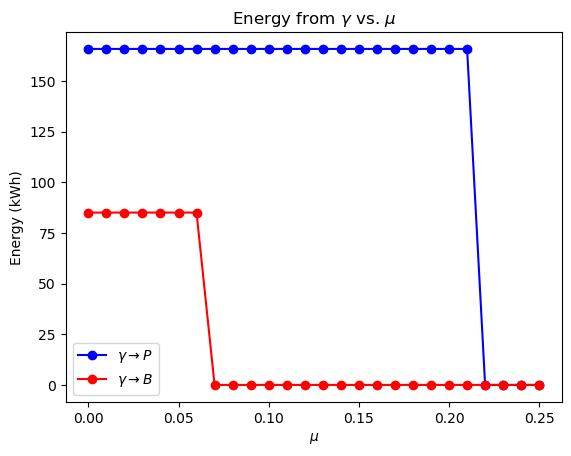

PyObject <matplotlib.legend.Legend object at 0x155e8b160>

In [164]:
using PyPlot

title(L"Energy from $\gamma$ vs. $\mu$")
plot(µ, Ppath, "b-o")
plot(µ, Bpath, "ro-")
xlabel(L"$\mu$")
ylabel("Energy (kWh)")
legend([L"$\gamma\rightarrow P$", L"$\gamma\rightarrow B$"])

In [15]:
total_supply = Dict(zip(days, sum(supply, 1)))

Dict{Symbol,Float64} with 3 entries:
  :Fri   => 16300.0
  :Weds  => 9000.0
  :Thurs => 6300.0

In [62]:
supply_from_producers = (getvalue(sum(flow_out[p, 4] for p in producers))) + (sum(demand[us, 4]))

625.8199999999999

In [65]:
getvalue(sum(flow_out[c, 4] for c in us)) + (sum(demand[us, 4]))

300.0

In [66]:
total_demand = Dict(zip(days, sum(demand, 1)))

Dict{Int64,Float64} with 4 entries:
  4 => 443.2
  2 => 294.1
  3 => 256.7
  1 => 247.3

In [18]:
net = Dict(zip(days, total_supply[t] - total_demand[t] for t in days))

Dict{Symbol,Any} with 3 entries:
  :Fri   => 16043.3
  :Weds  => 8752.7
  :Thurs => 6005.9

In [41]:
getvalue(sum(x[a, :Weds] for a in edges))

231.56940144478847

In [30]:
demand_from_consumers = (getvalue(sum(flow_in[c, :Weds] for c in consumers)))

205.23333333333335

In [34]:
demand_from_consumers = total_demand[:Weds] - sum(demand[us, :Weds])

247.29999999999998

In [84]:
getvalue(flow_in[:L, :Weds] + flow_in[:K, :Weds] + flow_in[:C, :Weds])

0.0

In [85]:
getvalue(flow_in[:P, :Weds])

74.13333333333334

In [31]:
supply_from_producers - demand_from_consumers

68.40273477812178

In [4]:
producers

5-element Array{Symbol,1}:
 :K    
 :L    
 :C    
 :alpha
 :beta 

In [33]:
supply_from_producers - total_demand[:Weds]

26.33606811145515

In [36]:
supply

6×3 Named Array{Float64,2}
Producer ╲ Day │    :Weds    :Thurs      :Fri
───────────────┼─────────────────────────────
:K             │   2000.0    1500.0    1000.0
:L             │   1500.0    2000.0    1500.0
:C             │   1500.0    2300.0    1800.0
:alpha         │   1500.0     300.0    7000.0
:beta          │   2500.0     200.0    5000.0
:gamma         │ 100000.0  100000.0  100000.0

In [126]:
for u in us
println("Supply from ", u, ": ", getvalue(flow_out[u, 4]) + demand[u, 4])
end

Supply from K: 100.0
Supply from L: 347.4530501089325
Supply from C: 120.0


In [149]:
append!([1; 2], 2)

3-element Array{Int64,1}:
 1
 2
 2

In [152]:
Ppath

52-element Array{Any,1}:
 165.918
  85.107
 165.918
  85.107
 165.918
  85.107
 165.918
  85.107
 165.918
  85.107
 165.918
  85.107
 165.918
   ⋮    
 165.918
   0.0  
 165.918
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  
   0.0  